**Cole Turner and Ethan Seal**

Fall 2019

CS343: Neural Networks

Project 4: Transfer Learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)
rgen = np.random.RandomState(1)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

*Sanity check that Tensorflow is installed correctly:*

Executing the following cell should return 3 

In [2]:
tf.print(tf.reduce_sum([tf.Variable(1), tf.Variable(2)]))

3


## Task 1) Implement ConvNet4 in Tensorflow, train/test on STL-10

### 1a) Use the high level `Keras::Sequential` API in Tensorflow 2.0 to implement the architecture of ConvNet4 from the last project. Train and test your network on the STL-10 dataset. 

Recall the `Keras::Sequential` common worflow:

- Build structure of network with `keras::Sequential`.
- Compile network with your choice of optimizer, loss, and metrics.
- Fit the model (remembering to pass in the appropriate training and validation sets). This results a history object that can be used to examine training/validation accuracy and loss.
- Evaluate the model on the test set. This returns test loss and accuracy.

**Notes**:
- You should use the usual STL-10 data acquistion and preprocessing code from your last project.
- You don't need to do a hyperparameter search. Values that worked on the CNN project should get you in the ballpark here. The goal is to show that you know how to put together a `keras::Sequential` model and have it work successfully.
- Tensorflow needs the RGB color channel AFTER the spatial dimensions. For example: (64, 64, 3), not (3, 64, 64). You may therefore need to slightly modify the preprocesssing pipeline for this project.

These documentation pages should be helpful:
- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary

In [3]:
import load_stl10_dataset
from preprocess_data import preprocess_stl, create_splits

In [4]:
stl_imgs, stl_labels = load_stl10_dataset.load()

Images are: (5000, 96, 96, 3)
Labels are: (5000,)
Resizing 5000 images to 32x32...Done!
Saving Numpy arrays the images and labels to ./numpy...Done!


In [5]:
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

In [6]:
# Preprocess image pixel values for the MLP net
stl_imgs, stl_labels = preprocess_stl(stl_imgs, stl_labels)
print(f'stl_imgs dtype is {stl_imgs.dtype} and it should be float64')
print(f'stl_imgs max is {np.max(stl_imgs[:, 1:]):.3f} and it should be 0.668')
print(f'stl_imgs shape is {stl_imgs.shape} and it should be (5000, 32, 32, 3)')
print(f'stl_labels span {stl_labels.min()}->{stl_labels.max()} and it should be 0->9')

imgs.shape (5000, 32, 32, 3)
stl_imgs dtype is float64 and it should be float64
stl_imgs max is 0.668 and it should be 0.668
stl_imgs shape is (5000, 32, 32, 3) and it should be (5000, 32, 32, 3)
stl_labels span 0->9 and it should be 0->9


In [7]:
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = create_splits(stl_imgs, stl_labels)  
print ('Train data shape: ', x_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('Validation data shape: ', x_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('dev data shape: ', x_dev.shape)
print ('dev labels shape: ', y_dev.shape)

data.shape (5000, 32, 32, 3)
Train data shape:  (3500, 32, 32, 3)
Train labels shape:  (3500,)
Test data shape:  (500, 32, 32, 3)
Test labels shape:  (500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
dev data shape:  (500, 32, 32, 3)
dev labels shape:  (500,)


### 1b) Make 2 "high quality" plots showing the following

- Plot the training and validation accuracy (y axis) over training epochs (x axis).
- Plot the training and validation loss (y axis) over epochs (x axis).

A high quality plot consists of:
- A useful title
- X and Y axis labels
- A legend

In [16]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=stl_imgs.shape[1:],filters=32, kernel_size=(7,7),padding="same", activation='relu',),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format="channels_last" ),
    tf.keras.layers.Flatten(input_shape=(16,16,32)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax") 
]) 
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) 
hist = model.fit(x_train, y_train, batch_size=4, epochs=20, validation_data=(x_val, y_val), verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               819300    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 825,046
Trainable params: 825,046
Non-trainable params: 0
_________________________________________________________________
Train on 3500 samples, validate on 500 samples
Epoch 1/20
3500/3500 - 9s - loss: 1.7747 - accuracy: 0.3391 - val_l

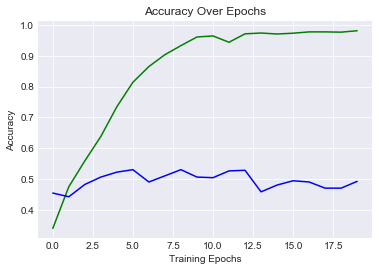

In [20]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.show()


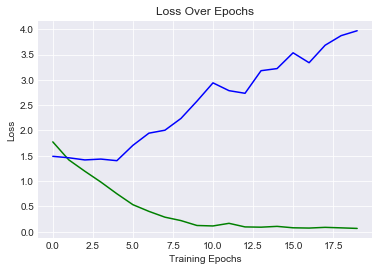

In [19]:
plt.plot(hist.history["loss"], label="Training Loss", color="green")
plt.plot(hist.history["val_loss"], label="Validation Loss", color="blue")
plt.title("Loss Over Epochs")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.show()

**Question 1:** What accuracy do you get on the STL-10 test set? Briefly summarize the hyperparameters that you used to obtain this result.

**Answer 1**

We used 20 epochs, a batch size of 4, a the default learning rate of .001. We get an accuracy of up to 53% but closer to 49% generally.



**Question 2:** How do the loss and accurary results compare to the CNN project?

**Answer 2**
The loss is similar and the accuracy is a bit higher in this project. It might be because the layers are slightly different or the default hyper parameters are a bit different, but we get slightly higher accuracy here. However, the difference is not drastic. The loss both heads to 0, though the loss falls faster here than it does on the other model we built in the CNN project.

## Task 2) Transfer learning

Use Tensorflow 2.0 to download the pre-trained MobileNetV2 network (you may also use InceptionV3, but MobileNetV2 likely will run noticeably faster on your machine). We will use transfer learning to accelerate training to solve a novel problem: **the binary classification task of discriminating whether an image is of a hotdog or not.**

### Overview of the task

- Run some hotdog-or-not dataset images through the network. How does the net seem to classify things correctly?
- Remove the output layer.
- Add a new Dense output layer.
- Freeze (disable) training on all non-output layers.
- Train the last layer on a food dataset. Assess performance. Plot some example images and their classification below

**TODO:**
- Get the **food dataset** on filer: `Courses/CS343/Course_Materials/hot-dog-not-hot-dog`. Copy it into a `data` subfolder in your project directory.
- Run the below code to load in the hot-dog-or-not dataset. Check the shapes to ensure everything is loaded in correctly. 

### 2a) Load in hotdot image dataset

In [21]:
ds_base_dir = 'data/hot-dog-not-hot-dog/numpy/'
hotdog_train_x = np.load(os.path.join(ds_base_dir, 'train_x.npy'))
hotdog_train_y = np.load(os.path.join(ds_base_dir, 'train_y.npy'))
hotdog_test_x = np.load(os.path.join(ds_base_dir, 'test_x.npy'))
hotdog_test_y = np.load(os.path.join(ds_base_dir, 'test_y.npy'))

print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (16000, 96, 96, 3)')
print(f'Test hotdog split shape: {hotdog_test_x.shape}. Should be (4000, 96, 96, 3)')

Training hotdog split shape: (16000, 96, 96, 3). Should be (16000, 96, 96, 3)
Test hotdog split shape: (4000, 96, 96, 3). Should be (4000, 96, 96, 3)


### 2b) Preprocess hotdog dataset

In [22]:
hotdog_train_x = 2*(hotdog_train_x - 0.5)
hotdog_test_x = 2*(hotdog_test_x - 0.5)

### 2c) Create hotdog validation set

In [23]:
VAL_PROP = 0.2  # proportion of trainng set to reserve for validation
VAL_SZ = int(VAL_PROP*len(hotdog_train_x))
hotdog_val_x = hotdog_train_x[-VAL_SZ:]
hotdog_val_y = hotdog_train_y[-VAL_SZ:]
hotdog_train_x = hotdog_train_x[:len(hotdog_train_x)-VAL_SZ]
hotdog_train_y = hotdog_train_y[:len(hotdog_train_y)-VAL_SZ]

print(f'Validation hotdog split shape: {hotdog_train_x.shape}. Should be (12800, 96, 96, 3)')

Validation hotdog split shape: (12800, 96, 96, 3). Should be (12800, 96, 96, 3)


### 2d) Load in pre-trained MobileNetV2 network.

**TODO:**
- Load in pre-trained MobileNetV2 network (look up constructor in `tf.keras.applications` or look at the tutorial from class) and set it to a variable called `model`. https://www.tensorflow.org/api_docs/python/tf/keras/applications
- Set the `trainable` field of the model object to be `False` (use dot notation).
- If you call the `summary()` method on the network object, you should see a table with many rows. The top and bottom rows should be:


    input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                           
    __________________________________________________________________________________________________
    out_relu (ReLU)                 (None, 3, 3, 1280)   0           Conv_1_bn[0][0]  

and you should see the following at the bottom:

    Total params: 2,257,984
    Trainable params: 0
    Non-trainable params: 2,257,984

In [45]:
model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),include_top=False,
                                               weights='imagenet')
model.trainable=False
model.summary()



Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

### 2e) Replace output layer

**TODO:**
- Create a Dense layer object with the correct number of units to deal with the hot-dog or not problem, which will be the new output layer. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
- Create a new `keras/Sequential` model object composed of a Python list of the following:
    - the original model object
    - "Flatten layer"
    - the dense output layer
- Compile the augmented model with the Adam optimizer (learning rate of 0.0001), binary_crossentropy loss, and accuracy metric. https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam https://www.tensorflow.org/api_docs/python/tf/losses

A summary on the augmented model should yield:

    Layer (type)                 Output Shape              Param #   
    =================================================================
    mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
    _________________________________________________________________
    flatten_4 (Flatten)          (None, 11520)             0         
    _________________________________________________________________
    dense_4 (Dense)              (None, 1)                 11521     
    =================================================================
    Total params: 2,269,505
    Trainable params: 11,521
    Non-trainable params: 2,257,984

**Question 3:** What is the accuracy and loss for the network with the untrained output layer?
**Answer:** Our accuracy is 50.2% and our loss is 7.64.

**Question 4:** Briefly defend your choice of number of units in the output layer.

**Answer:** Two different classes exist, hot dog or not hot dog. If we only have one output, that it is a hot dog, then everything else will be 0 if it is not a hot dog. Thus, we only need one output node.

In [54]:
mn_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
mn_model.summary()
mn_model.compile(optimizer='adam', learning_rate=.0001,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

loss, acc = mn_model.evaluate(hotdog_test_x, hotdog_test_y, verbose=2)
print(f'Accuracy: {acc}, Loss: {loss}')

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten_15 (Flatten)         (None, 11520)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11521     
Total params: 2,269,505
Trainable params: 11,521
Non-trainable params: 2,257,984
_________________________________________________________________
4000/1 - 19s - loss: 1.0070 - accuracy: 0.5305
Accuracy: 0.5304999947547913, Loss: 0.9105810918807984


### 2f) Fit the augmented model on the hotdog training data

**Notes**
- Remember to also pass in the hotdog validation data. Train for 10 epochs with a batch size of 32.
- Setting the verbose optional parameter to 2 will give you helpful printouts of performance on the validation set as it completes every epoch of training.


**NOTE:**
- If training time is taking much more 2.5 minutes per epoch on your computer, you could try reducing the number of data samples in train and validation. For example, by default train `N = 12800`. Try `N = 6400` instead. You could do the same for the validation set.

In [55]:
hist = mn_model.fit(hotdog_train_x, hotdog_train_y, 
                    validation_data=(hotdog_val_x,hotdog_val_y),
                     epochs=10,
                     verbose=2,
                     batch_size=32)

Train on 12800 samples, validate on 3200 samples
Epoch 1/10
12800/12800 - 111s - loss: 0.5472 - accuracy: 0.7754 - val_loss: 0.7907 - val_accuracy: 0.7534
Epoch 2/10
12800/12800 - 103s - loss: 0.3856 - accuracy: 0.8465 - val_loss: 0.6098 - val_accuracy: 0.7897
Epoch 3/10
12800/12800 - 107s - loss: 0.3286 - accuracy: 0.8692 - val_loss: 0.5815 - val_accuracy: 0.8050
Epoch 4/10
12800/12800 - 103s - loss: 0.3238 - accuracy: 0.8768 - val_loss: 0.5683 - val_accuracy: 0.8150
Epoch 5/10
12800/12800 - 104s - loss: 0.3080 - accuracy: 0.8830 - val_loss: 0.6340 - val_accuracy: 0.8106
Epoch 6/10
12800/12800 - 102s - loss: 0.3055 - accuracy: 0.8855 - val_loss: 0.8181 - val_accuracy: 0.7928
Epoch 7/10
12800/12800 - 104s - loss: 0.2782 - accuracy: 0.8976 - val_loss: 0.6305 - val_accuracy: 0.8141
Epoch 8/10
12800/12800 - 108s - loss: 0.2877 - accuracy: 0.8940 - val_loss: 0.9407 - val_accuracy: 0.7781
Epoch 9/10
12800/12800 - 107s - loss: 0.2724 - accuracy: 0.9020 - val_loss: 1.0198 - val_accuracy: 0.77

### 2g) Plot hotdog results

Produce 2 high quality plots showing the following:

- Training and validation loss over epoch.
- Training and validation accuracy over epoch.

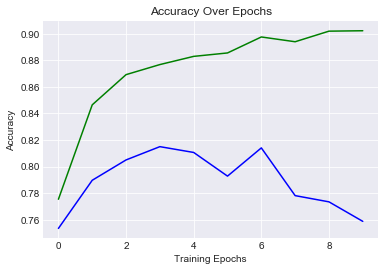

In [56]:
plt.plot(hist.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.show()

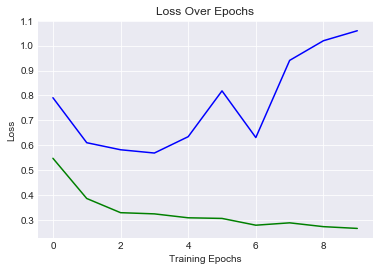

In [57]:
plt.plot(hist.history["loss"], label="Training Loss", color="green")
plt.plot(hist.history["val_loss"], label="Validation Loss", color="blue")
plt.title("Loss Over Epochs")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.show()

**Question 5:** What accuracy do you achieve on the test set? Briefly summarize the hyperparameters that were used in your model.

**Answer:** We achieve about 75